In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

import MI
import tqdm
import bvcopula
import vine as v

In [2]:
animal = 'A0' #ST260 -> A0 for short
day_name = 'D1' # DayN -> DN
# data_type = 'Ca' # Ca or spikes+kernel
exp_pref = f'{animal}_{day_name}'
exp_postfix = 'respSR_gV' # given smth
path_models = f"{conf.path2outputs}/{exp_pref}_{exp_postfix}"
path_models

'/home/nina/outputs/A0_D1_respSR_gV'

In [3]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [4]:
models_lists = lambda n: f"{path_models}/models_layer{n}.pkl"
WAICs = v.WAICs(models_lists)

[Errno 2] No such file or directory: '/home/nina/outputs/A0_D1_respSR_gV/models_layer40.pkl'
Loading stops and only the WAICs for lower trees are returned


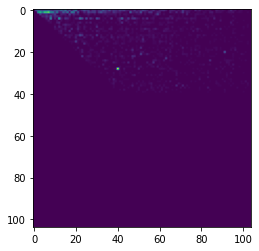

In [5]:
plt.imshow(-WAICs[:,:])

In [8]:
dataset_name = f"{conf.path2data}/ST260_Day1_respS_gV.pkl"#{exp_postfix}.pkl"
with open(dataset_name,'rb') as f:
    data = pkl.load(f)
X = data['X']
Y = data['Y']
# X,Y = utils.standard_loader(dataset_name)
N_points = 200
train_x = torch.tensor(X, device='cuda:1').float()
subset = torch.randperm(train_x.numel())[:N_points]
train_x = train_x[subset]
weight_files = lambda layer,n: f"{path_models}/layer{layer}/model_{exp_pref}_{exp_postfix}_{layer}-{layer+n+1}.pth"

likelihoods, vine = v.load(models_lists, weight_files, train_x)

In [ ]:
# [len(copula_layers[i]) for i in range(108)]
copula_layers = vine.layers
c, c1 = 0, 0
for layer in copula_layers:
    for copulas in layer:
        c+= 1
        if len(copulas.copulas)==1:
            if copulas.copulas[0].__name__ == "IndependenceCopula":
                c1 += 1
print(c1,c,c1/c,c-c1)

In [28]:
# _, vine = v.load(models_lists, weight_files, train_x, gp_particles=torch.Size([50]))
print(vine.layers[0][0].theta[0][0],vine.layers[0][0].theta[0].mean())
#tensor(-0.0466, device='cuda:1') tensor(-0.5867, device='cuda:1')
vine.layers[0][0].theta[0][0].clone()

tensor(0.1992, device='cuda:1') tensor(-0.7831, device='cuda:1')


tensor(0.1992, device='cuda:1')

In [29]:
# with open(f"{home}/results/D1UxFU_vine.pkl","wb") as f:
#     pkl.dump([copula_layers,vine],f)
mc_size=1500
sem_tol = 0.1
entropies = torch.zeros_like(train_x).expand(torch.Size([5])+train_x.shape)
for i in range(5):
    _, vine = v.load(models_lists, weight_files, train_x, gp_particles=torch.Size([50]))
    print(vine.layers[0][0].theta[0][0],vine.layers[0][0].theta[0].mean())
    %time entropy = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
    print(entropy[0],entropy.mean())
    entropies[i] = entropy.clone()

tensor(0.1392, device='cuda:1') tensor(-0.5664, device='cuda:1')
tensor(2.1167, device='cuda:1')
tensor(1.4971, device='cuda:1')
tensor(1.2161, device='cuda:1')
tensor(1.0529, device='cuda:1')
CPU times: user 9min 16s, sys: 384 ms, total: 9min 16s
Wall time: 9min 16s
tensor(-20.4899, device='cuda:1') tensor(-23.2148, device='cuda:1')
tensor(0.0028, device='cuda:1') tensor(-0.7355, device='cuda:1')
tensor(2.1124, device='cuda:1')
tensor(1.4820, device='cuda:1')
tensor(1.2103, device='cuda:1')
tensor(1.0472, device='cuda:1')
CPU times: user 8min 56s, sys: 264 ms, total: 8min 56s
Wall time: 8min 56s
tensor(-20.3211, device='cuda:1') tensor(-23.1702, device='cuda:1')
tensor(-0.1663, device='cuda:1') tensor(-0.6839, device='cuda:1')
tensor(2.1141, device='cuda:1')
tensor(1.4843, device='cuda:1')
tensor(1.2089, device='cuda:1')
tensor(1.0479, device='cuda:1')
CPU times: user 8min 45s, sys: 276 ms, total: 8min 45s
Wall time: 8min 45s
tensor(-20.0011, device='cuda:1') tensor(-23.1803, device='

In [ ]:
vineC = v.CVine(copula_layers[1:],train_x,device=train_x.device)
%time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)

In [15]:
entropy[:,0]

tensor([-20.2152, -20.2152, -20.2152, -20.2152, -20.2152], device='cuda:1')

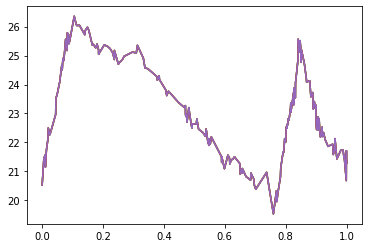

In [13]:
# x = data['Xr'][subset.cpu().numpy()]
# order = np.argsort(x)
# x = x[order]
# plt.plot(x,-entropy.cpu().numpy()[order])
# plt.plot(x,-entropyC.cpu().numpy()[order])
# plt.xlabel('time to entering reward zone, [sec]')
# plt.ylabel(r'$-H(Y,V|X)$')
# plt.axvline(0,color='k')
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
for i in range(5):
    y = -entropy[i].cpu().numpy()[order]
    plt.plot(x,y)

In [ ]:
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
y = -entropy.cpu().numpy()[order]
plt.plot(x,y)

In [ ]:
from utils import get_model
model = get_model(weight_files(0,1), likelihoods[0][1], 'cuda:1')
f = model.gp_model(train_x).rsample(torch.Size([10]))

# f = f.reshape(shape[0],-1)
f = torch.einsum('i...->...i', f)
shape = f.shape
print(f.shape)
ind = torch.rand(f.shape,device=f.device).argsort(dim = -1)
onehot = (ind==0)
# onehot[:,1,1]
res = f[onehot].reshape(shape[:-1])
# print(res.shape)
# # res = torch.zeros_like(f).scatter_(0, onehot, 1)
# # res[:,0,1]

# # res = res.reshape(shape)
# # f = f.reshape(shape)
res.shape

In [ ]:
for i in range(10):
    plt.plot(x,f[:,2,i].detach().cpu().numpy()[order])
plt.plot(x,res[:,2].detach().cpu().numpy()[order])

In [ ]:
mat = torch.tensor ([[11.0, 12, 13],[21, 22, 23],[31, 32, 33],[41, 42, 43]])
ind = torch.rand (4, 3).argsort (dim = 0)
res = torch.zeros (4, 3).scatter_ (0, ind, mat)
print(mat)
print(res)

In [ ]:
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
y = -entropy.cpu().numpy()[order]
plt.plot(x,y)

In [ ]:
entropy1 = entropy